# Classification Models

## Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nbimporter

import TrainTestEvalSplit as split

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Classification Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from yellowbrick.classifier import ClassPredictionError

import pickle

from sklearn.model_selection import KFold
from sklearn.utils import check_X_y
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectFromModel

## Import File

In [26]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,weekday,is_weekend,Sensor,SensorLongitude,SensorLatitude,CrowdednessCount,LonScaled,LatScaled,...,Nieuwmarkt score,Nieuwmarkt weight,Nieuwezijds Kolk score,Nieuwezijds Kolk weight,Dam score,Dam weight,Spui score,Spui weight,Centraal Station score,Centraal Station weight
0,2018-03-11,100,6.0,1.0,GAWW-04,4.897908,52.373283,886,-0.558826,0.035969,...,0.000000,0.978944,0.000000,0.616678,-32.179221,-0.312420,-0.000000,-1.140386,297.734037,0.629459
1,2018-03-11,2100,6.0,1.0,GAWW-07,4.900441,52.374414,1603,1.966352,1.066966,...,396.612265,1.142975,5.596253,0.028122,-2008.443214,-1.585196,-370.823855,-2.767342,4117.774978,1.066781
2,2018-03-11,2100,6.0,1.0,GAWW-08,4.897193,52.371650,21,-1.271546,-1.452500,...,306.731105,0.883951,85.461513,0.429455,-107.617256,-0.084939,-71.079754,-0.530446,262.901130,0.068109
3,2018-03-11,2100,6.0,1.0,GAWW-09,4.898479,52.375040,88,0.011331,1.637575,...,299.730494,0.863777,135.285034,0.679824,-832.481652,-0.657049,-252.977149,-1.887889,3940.747665,1.020919
4,2018-03-11,2100,6.0,1.0,GAWW-10,4.898808,52.372369,49,0.338729,-0.797289,...,402.696352,1.160508,44.878993,0.225523,-918.302668,-0.724785,-187.014683,-1.395632,2000.274786,0.518206


## Train/Test/Eval

In [27]:
size = 0.8
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [28]:
full_df = split.clasCrowdednessCounts(full_df)

In [59]:
x_train, y_train, x_test, y_test, x_eval, y_eval, train_dates = split.trainTestSplit(full_df, size)

In [55]:
x_train.columns

Index(['Date', 'weekday', 'is_weekend', 'LonScaled', 'LatScaled', 'is_event',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'Nieuwmarkt score', 'Nieuwmarkt weight', 'Nieuwezijds Kolk score',
       'Nieuwezijds Kolk weight', 'Dam score', 'Dam weight', 'Spui score',
       'Spui weight', 'Centraal Station score', 'Centraal Station weight'],
      dtype='object')

## Feature Selection

In [30]:
X=x_train.drop(columns={"Date"})
y=y_train["CrowdednessCount"]

feature_model = SelectFromModel(RandomForestClassifier(n_estimators=250, random_state=42))
feature_model.fit(X, y)

selected_feat= X.columns[(feature_model.get_support())]

print(selected_feat)

Index(['hour_sin', 'hour_cos', 'Nieuwmarkt score', 'Nieuwmarkt weight',
       'Nieuwezijds Kolk score', 'Dam score', 'Centraal Station score'],
      dtype='object')


## Models

### Baseline
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

#### Training

In [41]:
base = DummyClassifier(strategy="stratified", random_state=42)

In [60]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, val_index in kf.split(train_dates):
    
#     x_train_con, y_train_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
#                                         y=y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])

    x = x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"})
    y = y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"]
    
    base.fit(x, y)
    
#     x_val_con, y_val_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
#                                     y=y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])

    x_val = x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"})
    y_val = y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"]
    
    y_pred_base = base.predict(x_val)
    
    mean_acc += accuracy_score(y_val, y_pred_base)

    mean_precision += precision_score(y_val, y_pred_base, average=None)
    mean_recall += recall_score(y_val, y_pred_base, average=None)
    mean_f1_score += f1_score(y_val, y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  24.87 

For label 1
Mean Precision Score:  24.3
Mean Recall Score:  24.0
Mean F1 Score:  24.14 

For label 2
Mean Precision Score:  25.0
Mean Recall Score:  25.31
Mean F1 Score:  25.15 

For label 3
Mean Precision Score:  25.11
Mean Recall Score:  24.81
Mean F1 Score:  24.89 

For label 4
Mean Precision Score:  25.19
Mean Recall Score:  25.51
Mean F1 Score:  25.27 



#### Test

Accuracy Score:  0.24746376811594203
              precision    recall  f1-score   support

           1       0.24      0.24      0.24      2767
           2       0.25      0.25      0.25      2781
           3       0.24      0.25      0.25      2662
           4       0.26      0.25      0.25      2830

   micro avg       0.25      0.25      0.25     11040
   macro avg       0.25      0.25      0.25     11040
weighted avg       0.25      0.25      0.25     11040



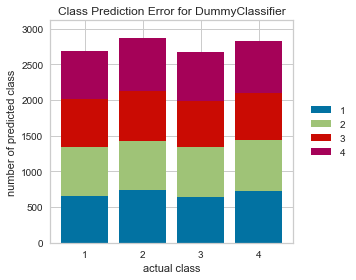

In [61]:
y_pred_test_base = base.predict(x_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred_test_base))
print(classification_report(y_test, y_pred_test_base))

visualizer = ClassPredictionError(
    base
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_test, y_test)
g = visualizer.poof()

### Random Forrest Classifier 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [44]:
rfc = RandomForestClassifier(n_estimators=375, criterion='entropy', max_features='log2', bootstrap=True,
                            class_weight=None)

#### Training

In [62]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, val_index in kf.split(train_dates):
    
    x = x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"})
    y = y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"]
    
    rfc.fit(x, y)
    
    x_val = x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"})
    y_val = y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"]
    
    y_pred_base = rfc.predict(x_val)
    
    mean_acc += accuracy_score(y_val, y_pred_base)

    mean_precision += precision_score(y_val, y_pred_base, average=None)
    mean_recall += recall_score(y_val, y_pred_base, average=None)
    mean_f1_score += f1_score(y_val, y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  87.13 

For label 1
Mean Precision Score:  87.75
Mean Recall Score:  83.72
Mean F1 Score:  85.68 

For label 2
Mean Precision Score:  83.71
Mean Recall Score:  82.89
Mean F1 Score:  83.29 

For label 3
Mean Precision Score:  87.98
Mean Recall Score:  88.21
Mean F1 Score:  88.08 

For label 4
Mean Precision Score:  88.95
Mean Recall Score:  93.64
Mean F1 Score:  91.22 



#### Hyperparameter Tuning

In [37]:
rfc = RandomForestClassifier()

n_estimators = [325, 350, 375]
criterion = ["gini", "entropy"]
max_features = ["log2", "auto", None]
bootstrap = [True]
oob_score = [True, False]
class_weight = ["balanced", "balanced_subsample", None]

params = {"n_estimators": n_estimators,
         "criterion": criterion,
         "max_features": max_features,
         "bootstrap": bootstrap,
          "oob_score": oob_score,
         "class_weight": class_weight}

scores = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]

hyp = RandomizedSearchCV(estimator=rfc, param_distributions=params, n_iter=10, scoring=scores, n_jobs=4, cv=10,
                        random_state=42, refit="f1_weighted")

rfc_model = hyp.fit(x_eval, y_eval)

In [38]:
print("Best estimator: ", rfc_model.best_estimator_)
print("Best F1 score: ", rfc_model.best_score_)

Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=375, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best F1 score:  0.8002979502516637


#### Test

Accuracy Score:  0.8735507246376811
              precision    recall  f1-score   support

           1       0.88      0.82      0.85      2767
           2       0.81      0.84      0.82      2781
           3       0.89      0.89      0.89      2662
           4       0.91      0.95      0.93      2830

   micro avg       0.87      0.87      0.87     11040
   macro avg       0.87      0.87      0.87     11040
weighted avg       0.87      0.87      0.87     11040



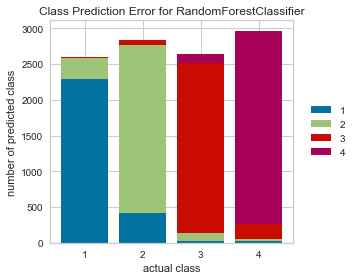

In [63]:
y_pred_test_rfc = rfc.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred_test_rfc))
print(classification_report(y_test, y_pred_test_rfc))

visualizer = ClassPredictionError(
    rfc
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_test, y_test)
g = visualizer.poof()

#### Save Model to File

In [66]:
filename = "../../../Data_thesis/Models/rfc_model.sav"

pickle.dump(rfc, open(filename, 'wb'))

### XGBoost 
Implement [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

#### Training

In [49]:
xgbc = xgb.XGBClassifier(learning_rate=0.05, n_estimators=200, booster='gbtree', objective='multi:softprob',
                        random_state=42, n_jobs=4)

In [64]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, val_index in kf.split(train_dates):
    
    x = x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"})
    y = y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"]
    
    xgbc.fit(x, y)
    
    x_val = x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"})
    y_val = y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"]
    
    y_pred_base = xgbc.predict(x_val)
    
    mean_acc += accuracy_score(y_val, y_pred_base)

    mean_precision += precision_score(y_val, y_pred_base, average=None)
    mean_recall += recall_score(y_val, y_pred_base, average=None)
    mean_f1_score += f1_score(y_val, y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  81.36 

For label 1
Mean Precision Score:  86.39
Mean Recall Score:  78.43
Mean F1 Score:  82.2 

For label 2
Mean Precision Score:  76.38
Mean Recall Score:  77.13
Mean F1 Score:  76.74 

For label 3
Mean Precision Score:  80.81
Mean Recall Score:  77.96
Mean F1 Score:  79.35 

For label 4
Mean Precision Score:  82.34
Mean Recall Score:  91.92
Mean F1 Score:  86.83 



#### Hyperparameter Tuning

In [47]:
xgbc = xgb.XGBClassifier()

learning_rate = [0.05, 0.1, 0.25, 0.5]
n_estimators = [200, 225, 250]
booster = ["gbtree"]
objective = ["multi:softmax", "multi:softprob"]

params = {"learning_rate": learning_rate,
         "n_estimators": n_estimators,
         "booster": booster,
         "objective": objective}

scores = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]

hyp = RandomizedSearchCV(estimator=xgbc, param_distributions=params, n_iter=10, scoring=scores, n_jobs=4, cv=10,
                        random_state=42, refit="f1_weighted")

xgbc_model = hyp.fit(x_eval, y_eval)

In [48]:
print("Best estimator: ", xgbc_model.best_estimator_)
print("Best F1 score: ", xgbc_model.best_score_)

Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Best F1 score:  0.6903379428460056


#### Test

Accuracy Score:  0.8161231884057971
              precision    recall  f1-score   support

           1       0.87      0.77      0.81      2767
           2       0.74      0.78      0.76      2781
           3       0.82      0.79      0.80      2662
           4       0.85      0.93      0.88      2830

   micro avg       0.82      0.82      0.82     11040
   macro avg       0.82      0.82      0.82     11040
weighted avg       0.82      0.82      0.82     11040



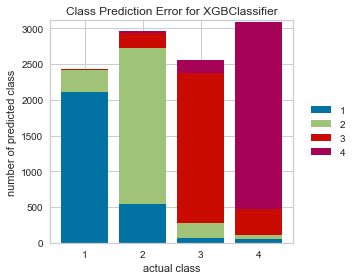

In [65]:
y_pred_test_xgbc = xgbc.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred_test_xgbc))
print(classification_report(y_test, y_pred_test_xgbc))

visualizer = ClassPredictionError(
    xgbc
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_test, y_test)
g = visualizer.poof()

#### Save Model to File

In [67]:
filename = "../../../Data_thesis/Models/xgbc_model.sav"

pickle.dump(xgbc, open(filename, 'wb'))